In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from hp_pred.databuilder import DataBuilder

/home/aubouinb/ownCloud/Code/hypotension_pred/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# all constants
caseid = 6247#5388
dataset_path = Path('data/datasets/30_s_dataset/')
databuilder = DataBuilder.from_json(dataset_path)
databuilder.raw_data_folder = databuilder.raw_data_folder / f"case-{caseid:04d}.parquet"
case_data, _ = databuilder._import_raw()
case_data = case_data.reset_index("caseid", drop=True)
sampled_data = databuilder._preprocess_sampling(case_data.copy())
filtered_data = databuilder._preprocess_peak(sampled_data.copy())
smoothed_data = databuilder._preprocess_smooth(filtered_data.copy())
filled_data = databuilder._preprocess_fillna(smoothed_data.copy())

label, label_id = databuilder._labelize(filled_data)
filled_data["label"] = label
filled_data["label_id"] = label_id


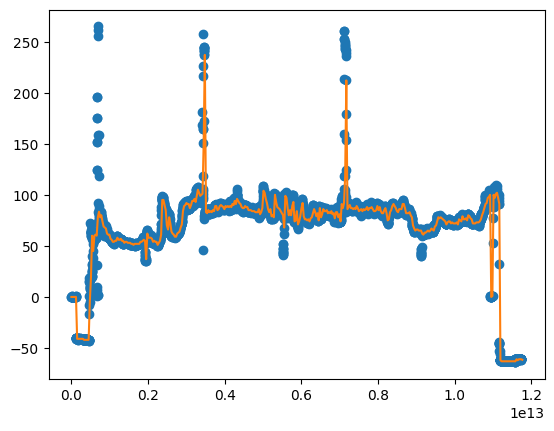

In [3]:
plt.plot(case_data.index, case_data.mbp, 'o')
plt.plot(sampled_data.index, sampled_data.mbp)

In [4]:
len(filled_data.label.values*100)

355

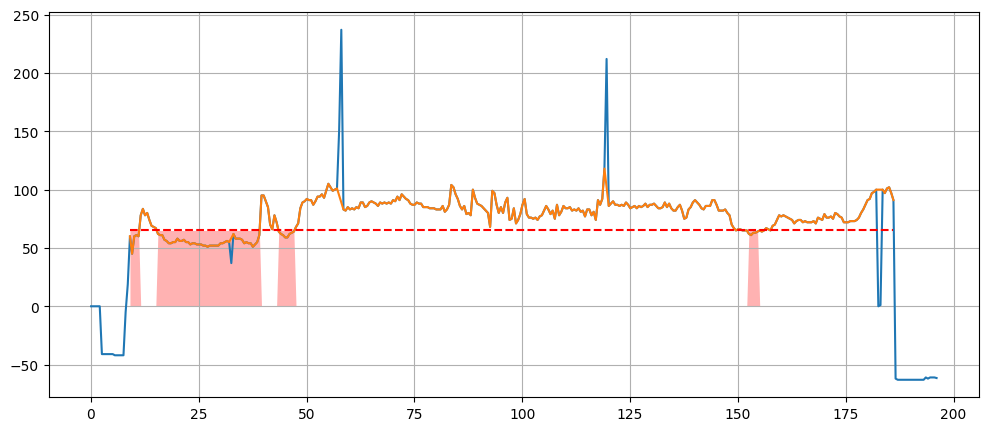

In [5]:
plt.figure(figsize=(12, 5))
filled_data['time'] = filled_data.index
x = filled_data.time.dt.total_seconds().astype(int).to_numpy() / 60
plt.fill_between(x, np.ones_like(x)*0, filled_data.label.clip(lower=0)*65, alpha=0.3, color='red', linewidth=0)
sampled_data['time'] = sampled_data.index
x2 = sampled_data.time.dt.total_seconds() / 60
plt.plot(x2, sampled_data.mbp)
plt.plot(x, filled_data.mbp)
plt.hlines(65, x[0], x[-1], color='red', linestyle='--')
plt.grid()
plt.show()



In [6]:
databuilder._create_segments(filled_data.copy(), caseid)

segments = pd.read_parquet(dataset_path / f"cases/case{caseid:04d}.parquet")

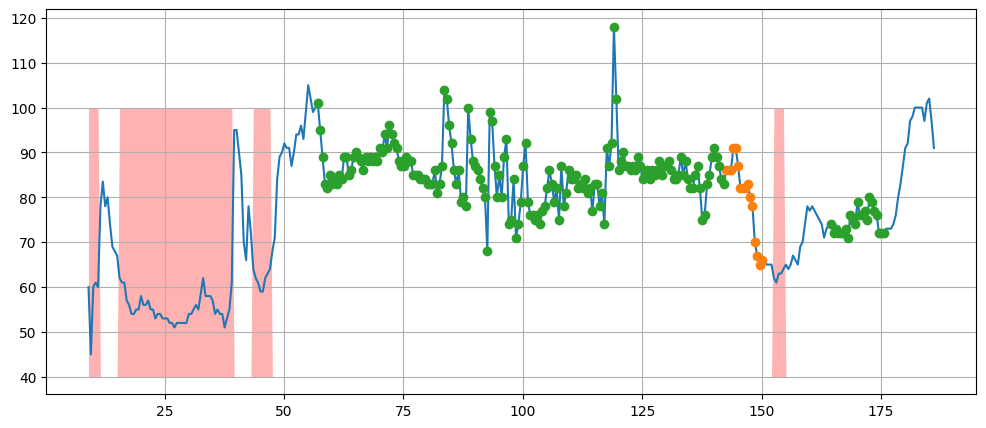

In [7]:
plt.figure(figsize=(12, 5))
plt.plot(x, filled_data.mbp)
plt.fill_between(x, np.ones_like(x)*40, filled_data.label.clip(lower=0.4)*100, alpha=0.3, color='red', linewidth=0)

segment_hypo = segments[segments.label == 1]
segment_normo = segments[segments.label == 0]

plt.plot(segment_hypo.time/ np.timedelta64(1, 's') /60, segment_hypo.last_map_value, 'o')
plt.plot(segment_normo.time/ np.timedelta64(1, 's') /60, segment_normo.last_map_value, 'o')
plt.grid()
plt.show()

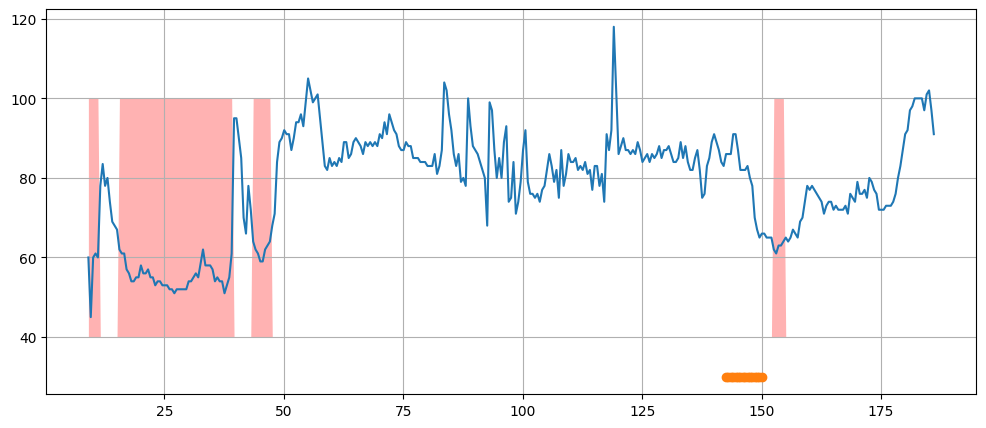

In [8]:
plt.figure(figsize=(12, 5))
plt.plot(x, filled_data.mbp)
plt.fill_between(x, np.ones_like(x)*40, filled_data.label.clip(lower=0.4)*100, alpha=0.3, color='red', linewidth=0)

label_id = segment_hypo.label_id.str.split("_").str[0].astype(float)
plt.plot(segment_hypo.time/ np.timedelta64(1, 's') /60, label_id*10, 'o')

plt.grid()
plt.show()

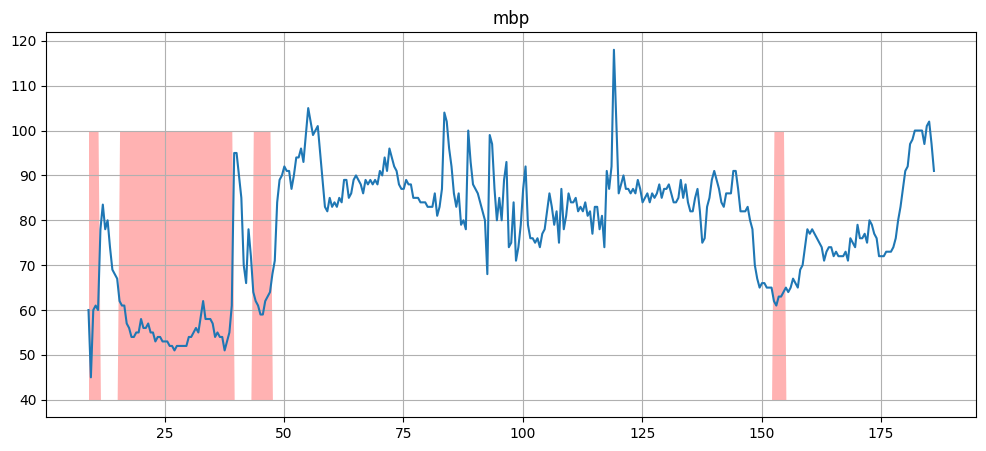

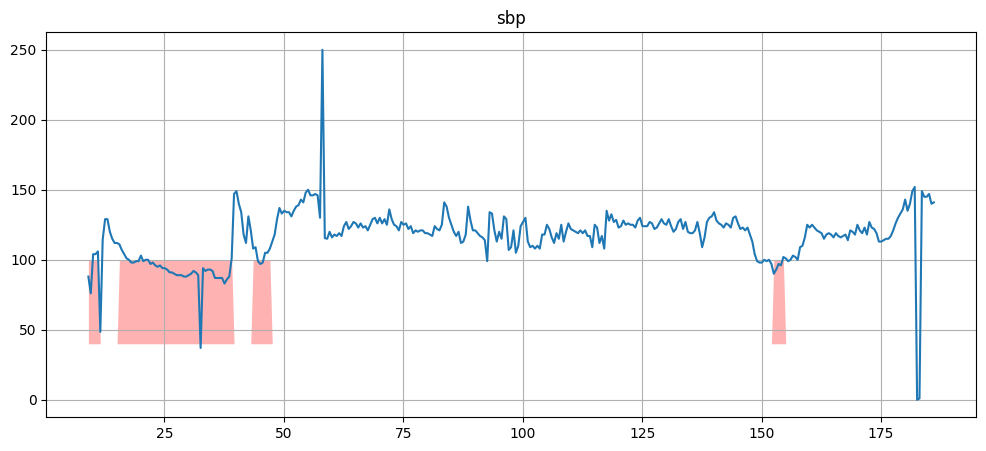

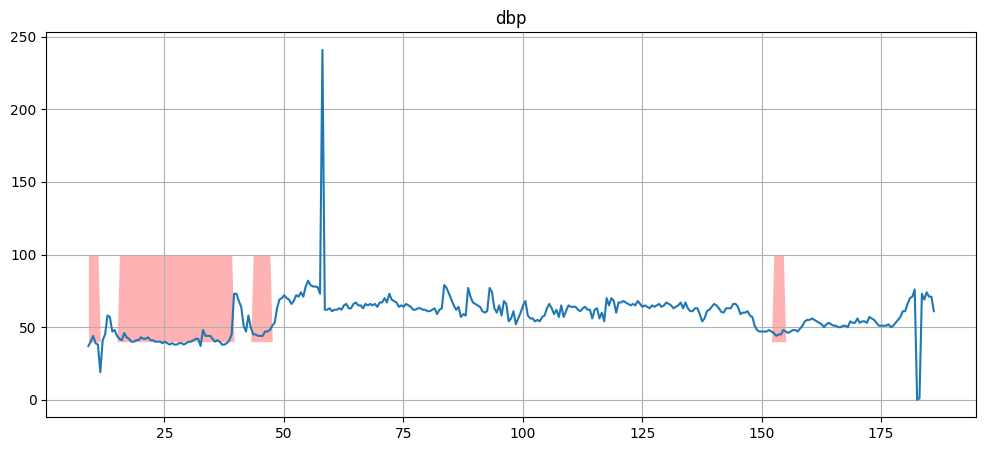

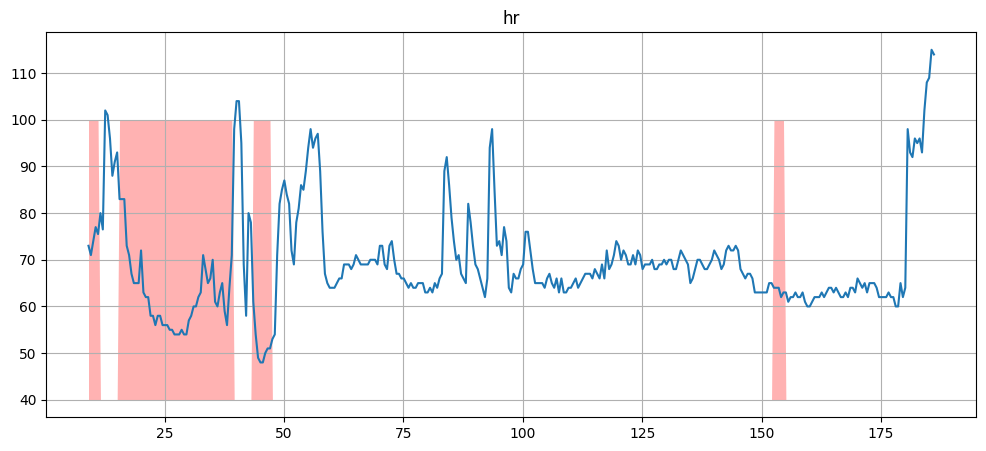

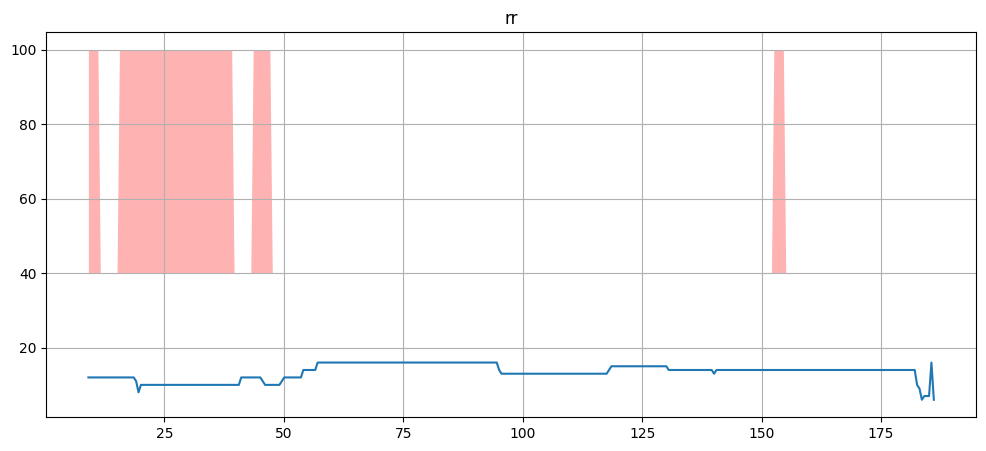

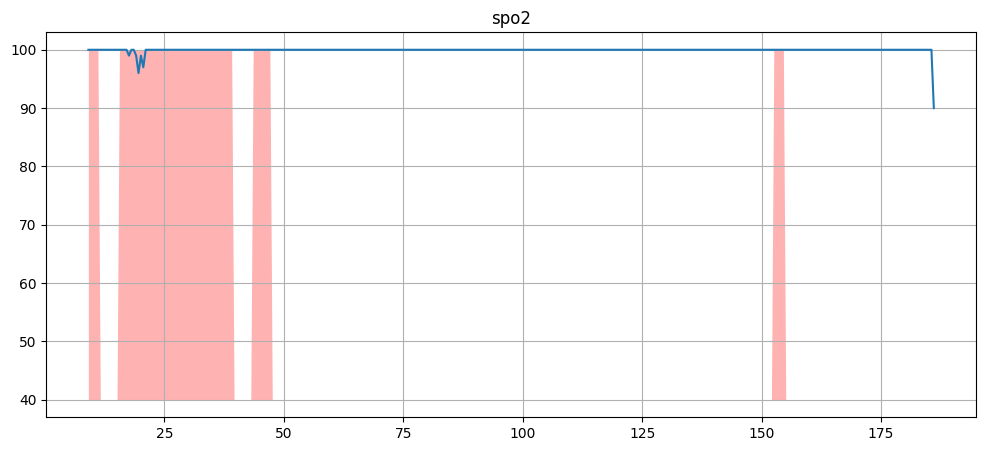

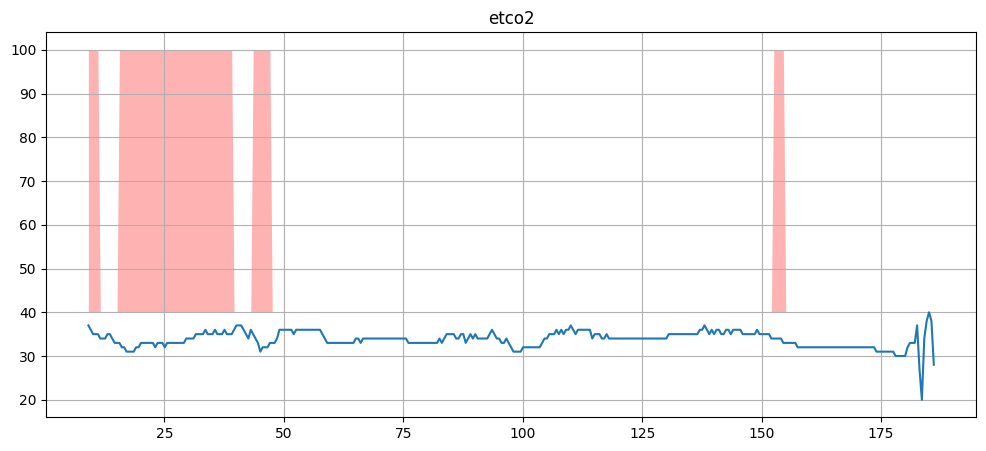

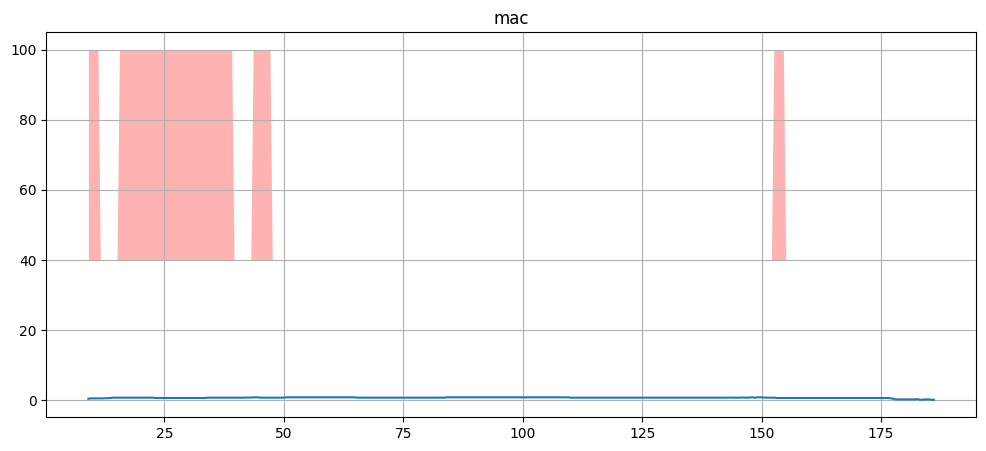

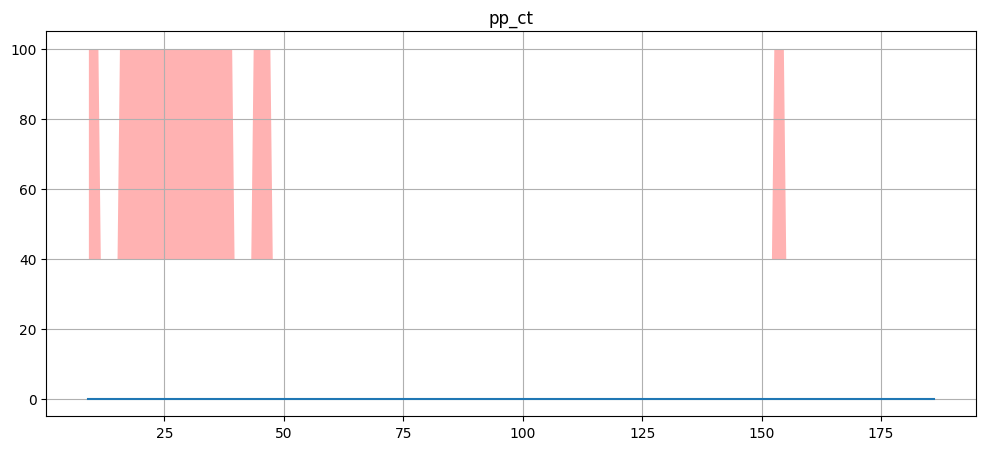

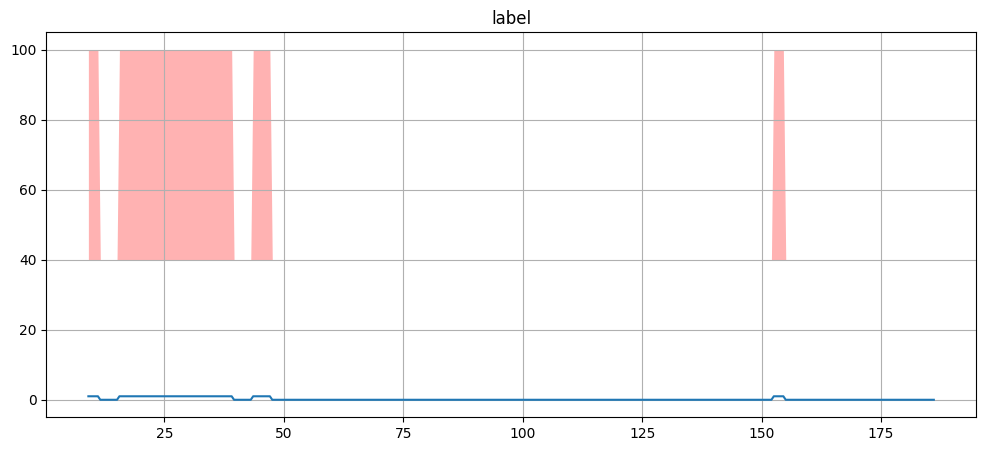

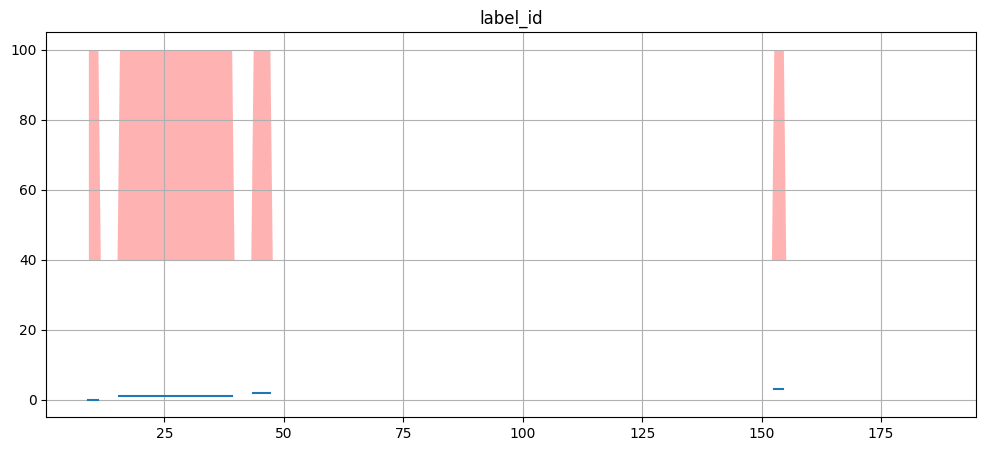

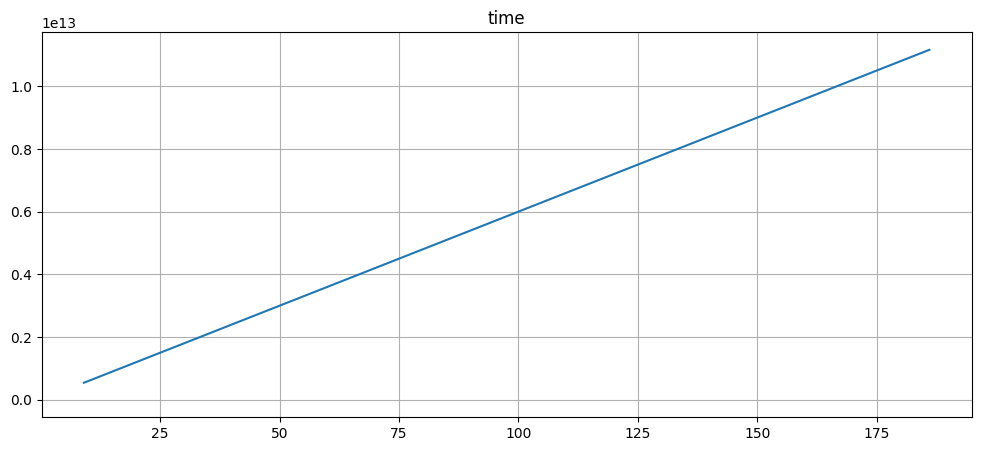

In [9]:
for signal in filled_data.columns:
    plt.figure(figsize=(12, 5))
    plt.plot(x, filled_data[signal])
    plt.fill_between(x, np.ones_like(x)*40, filled_data.label.clip(lower=0.4)*100, alpha=0.3, color='red', linewidth=0)
    plt.grid()
    plt.title(signal)
    plt.show()